# Joint fitting XRT and GBM data with XSPEC models

### Goals

3ML is designed to properly joint fit data from different instruments with thier instrument dependent likelihoods.
We demostrate this with joint fitting data from GBM and XRT while simultaneously showing hwo to use the XSPEC models form **astromodels**

### Setup

You must have you HEASARC initiated so that **astromodels** can find the XSPEC libraries. 




In [1]:
%matplotlib inline
from threeML import *
import os


WARNING CppInterfaceNotAvailable: The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)




Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!

Loading xspec models...


WARNING GSLNotAvailable: The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.


WARNING RuntimeWarning: The current value of the parameter switch was above the new maximum 1.0.


WARNING RuntimeWarning: The current value of the parameter specfile was above the new maximum 1.0.



done
Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING UserWarning: ROOT minimizer not available


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiGBM_TTE_Like.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiLATLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/HAWCLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.fra

## Load XRT data

Make a likelihood for the XRT including all the appropriate files

Currently using 1024 channels out of 1024
Auto-probed noise models:
- observation: poisson
- background: poisson
Range 0.3-10.0 translates to channels 29-999
Now using 971 channels out of 1024
Using 392 bins


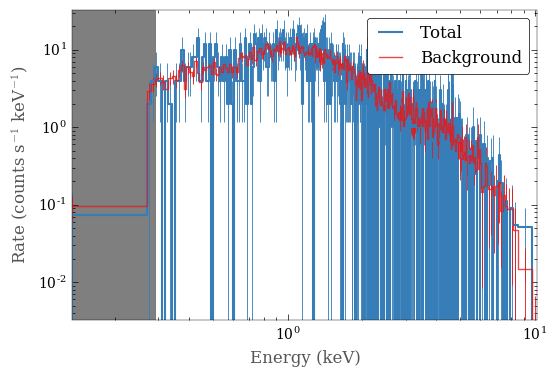

In [5]:
trigger="GRB110731A"
dec=-28.546
ra=280.52
xrt_dir='xrt'
xrt = SwiftXRTLike("XRT",pha_file=os.path.join(xrt_dir,"xrt_src.pha"),
                   bak_file=os.path.join(xrt_dir,"xrt_bkg.pha"),
                   rsp_file=os.path.join(xrt_dir,"xrt.rmf"),
                   arf_file=os.path.join(xrt_dir,"xrt.arf"))



xrt.set_active_measurements("0.3-10.0")

xrt.rebin_on_background(10)

xrt.view_count_spectrum()

## Load GBM data

Load all the GBM data you need and make appropriate background, source time, and energy selections. Make sure to check the light curves! 

In [6]:

gbm_dir=os.path.join('gbm','bn110731A')

# Select the time interval
src_selection = "100.169342-150.169342"

nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(gbm_dir,"glg_tte_n3_bn110731465_v00.fit"),
                         "20-90,160-250", # background selection
                         src_selection,          # source interval
                         rsp_file=os.path.join(gbm_dir, "glg_cspec_n3_bn110731465_v00.rsp2"))


Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING UserWarning: No TLMIN keyword found. This DRM is improper. Assuming TLMIN=1


WARNING VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future



View the light curve

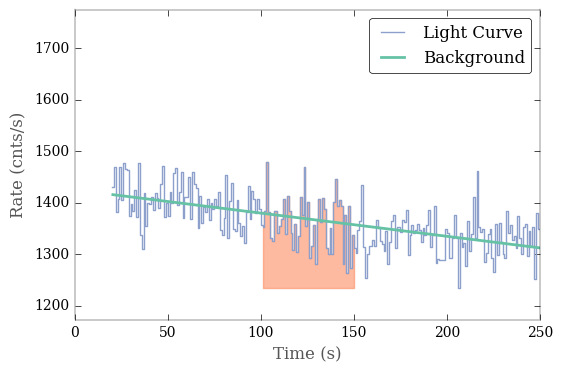

In [7]:
nai3.view_lightcurve(20,250)

Make energy selections and check them out

Range 8-900 translates to channels 4-123
Now using 120 channels out of 128


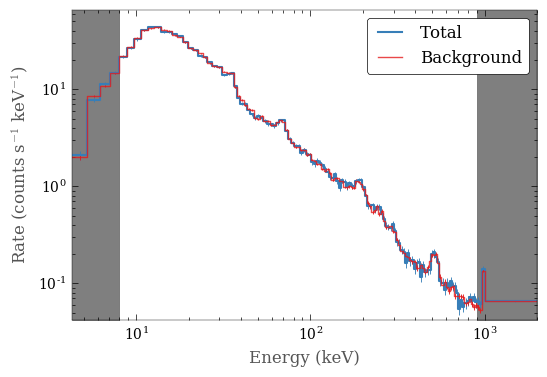

In [8]:
nai3.set_active_measurements("8-900")
nai3.view_count_spectrum()

## Setup the model

**astromodels** allows you to use XSPEC models if you have XSPEC installed.
Set all the normal parameters you would in XSPEC and build a model the normal **3ML/astromodel** way!


In [9]:
xspec_abund('angr')

spectral_model =  XS_phabs()* XS_zphabs() * XS_powerlaw()


spectral_model.nh_1=0.101
spectral_model.nh_1.fix = True

spectral_model.nh_2=0.1114424
spectral_model.nh_2.fix = True

spectral_model.redshift_2 = 0.618
spectral_model.redshift_2.fix =True

In [10]:
spectral_model.display()

* description: ((XS_phabs{1} * XS_zphabs{2}) * XS_powerlaw{3})
  * formula: (no latex formula available)
  * parameters: 
    * nh_1: 
      * value: 0.101
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * nh_2: 
      * value: 0.1114424
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * redshift_2: 
      * value: 0.618
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -0.999
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: False
    * phoindex_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -3.0
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: True
    * norm_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: None
      * unit: keV / (cm2 s)
      * delta: 0.1
      * free: True

## Setup the joint likelihood

Create a point source object and model. 

Load the data into a data list and create the joint likelihood


In [11]:
ptsrc = PointSource(trigger,ra,dec,spectral_shape=spectral_model)
model = Model(ptsrc)

data = DataList(xrt,nai3)

jl = JointLikelihood(model, data, verbose=False)
model.display()

RuntimeError: Xspec model XS_zphabs cannot have units of 1 / (cm2 keV s)

## Fitting

### Maximum Likelihood style

In [14]:
res = jl.fit()

Best fit values:



Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.03 +/- 0.05,
GRB110731A.spectrum.main.composite.norm_3,0.209 +/- 0.008,keV / (cm2 s)



NOTE: errors on parameters are approximate. Use get_errors().

Nuisance parameters:



Name,Value,Unit
InterCalib_of_XRT,1,
InterCalib_of_NAI,1,



Correlation matrix:



1.00,0.60
0.60,1.00



Minimum of -logLikelihood is: 1737.26349199

Contributions to the -logLikelihood at the minimum:



Detector,-LogL
XRT,842.94
NAI3,894.32


In [15]:
res = jl.get_errors()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.03 -0.04 +0.07,
GRB110731A.spectrum.main.composite.norm_3,0.209 -0.009 +0.009,keV / (cm2 s)


 [*********************100%***********************]  completed in 1.4 s

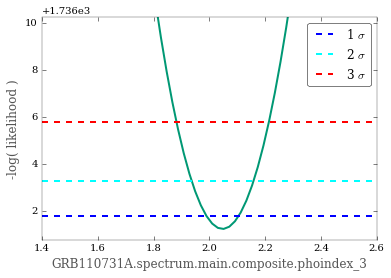

In [16]:
res = jl.get_contours(spectral_model.phoindex_3,1.5,2.5,50)

 [*********************100%***********************]  completed in 4.7 s

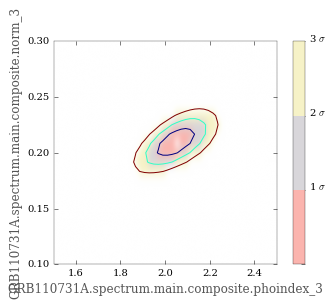

In [17]:
res = jl.get_contours(spectral_model.norm_3,.1,.3,25,spectral_model.phoindex_3,1.5,2.5,50)

### And then go Bayesian!

In [102]:
spectral_model.phoindex_3.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
spectral_model.norm_3.prior = Log_uniform_prior(lower_bound=1E-5, upper_bound=1)

In [106]:
bayes = BayesianAnalysis(model, data)

In [107]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...

 [*********************100%***********************]  completed in 18.6 s

Sampling...

 [**********************99%***********************]  992 / 1000 in 180.6 s (0:00:01 remaining)
Mean acceptance fraction: 0.71286


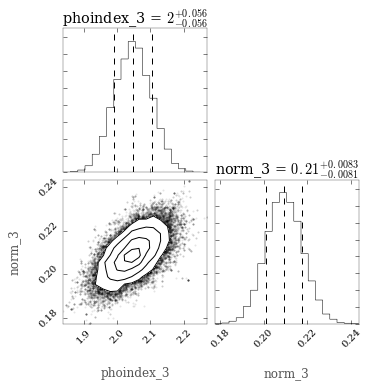

In [108]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)


In [110]:
bayes.get_highest_density_interval()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.05 -0.11 +0.11,
GRB110731A.spectrum.main.composite.norm_3,0.209 -0.016 +0.016,keV / (cm2 s)


OrderedDict([('GRB110731A.spectrum.main.composite.phoindex_3',
              {'lower bound': 1.9420550721054672,
               'median': 2.0473012995313451,
               'upper bound': 2.1563300384857449}),
             ('GRB110731A.spectrum.main.composite.norm_3',
              {'lower bound': 0.19311281485537479,
               'median': 0.20935989107363939,
               'upper bound': 0.22576779703065428})])